In [1]:
import os
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import uproot

from mu2etools import *
from mu2etools import wideband
hep.style.use('ATLAS')

In [2]:
DATASET = 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.root'

In [3]:
runs = [1312,1341]
processor = wideband.DataProcessor(usexroot=True, treename='run', runlist=runs, userunlist=True, remove=False)
filelist_data = processor.getFilelist(DATASET)
#append "run" at the end of each file name
filelist_data = ["{}{}".format(i, ":run") for i in filelist_data]

In [5]:
varlist=['PEs', 'PEsTemperatureCorrected', 'eventNumber','meanTemperatures']

thresh = np.linspace(10, 130, 25, endpoint=True)
pass_1_126_high = np.zeros_like(thresh)
pass_2_126_high = np.zeros_like(thresh)
pass_1_126_low = np.zeros_like(thresh)
pass_2_126_low = np.zeros_like(thresh)
pass_module126_1of2_high = np.zeros_like(thresh)
pass_module126_1of2_low = np.zeros_like(thresh)
nTrig_module126_high = np.zeros_like(thresh)
nTrig_module126_low = np.zeros_like(thresh)

pass_1_127_high = np.zeros_like(thresh)
pass_2_127_high = np.zeros_like(thresh)
pass_1_127_low = np.zeros_like(thresh)
pass_2_127_low = np.zeros_like(thresh)
pass_module127_1of2_high = np.zeros_like(thresh)
pass_module127_1of2_low = np.zeros_like(thresh)
nTrig_module127_high = np.zeros_like(thresh)
nTrig_module127_low = np.zeros_like(thresh)

highT = False

allevents = 0
highTevents = 0
lowTevents = 0

allfiles = 0
filesloaded = 0

for idx, filename in enumerate(filelist_data):
    try:
        with uproot.open(filename) as file:
            for ar in file.iterate(step_size="10MB", 
                                           filter_name=varlist, 
                                           report=False, library='ak'):
                allevents += len(ar["eventNumber"])
                if '1312' in filename:
                    highT = True
                if '1341' in filename:
                    highT = False

                ar["PEsTC"] = ak.where(ar["PEsTemperatureCorrected"] >= 5, ar["PEsTemperatureCorrected"], 0)
                ar["PEs"] = ak.where(ar["PEs"] >= 5, ar["PEs"], 0)

                
                FEB0_1 = (ak.sum(ar["PEs"][:,0,36:60], axis=-1)>10) #42:64
                FEB1_0 = (ak.sum(ar["PEs"][:,1,4:28], axis=-1)>10) #0:32

                FEB4_0 = (ak.sum(ar["PEs"][:,4,4:28], axis=-1)>10) #10:22
                FEB5_1 = (ak.sum(ar["PEs"][:,5,36:60], axis=-1)>10)

                ar_126 = ar[FEB4_0 & FEB5_1]
                ar_127 = ar[FEB1_0 & FEB0_1]

                for j in range(len(thresh)):
                    FEB1_1 = (ak.sum(ar_127["PEsTC"][:,1,32:64], axis=-1)>thresh[j])
                    FEB0_0 = (ak.sum(ar_127["PEsTC"][:,0,0:32], axis=-1)>thresh[j])
                    nHits_127 = ak.values_astype(FEB1_1, "int") + ak.values_astype(FEB0_0, "int")

                    FEB4_1 = (ak.sum(ar_126["PEsTC"][:,4,32:64], axis=-1)>thresh[j])
                    FEB5_0 = (ak.sum(ar_126["PEsTC"][:,5,0:32], axis=-1)>thresh[j])
                    nHits_126 = ak.values_astype(FEB4_1, "int") + ak.values_astype(FEB5_0, "int")

                    if highT:
                        pass_1_127_high[j] += ak.count(ar_127[FEB1_1]["eventNumber"])
                        pass_2_127_high[j] += ak.count(ar_127[FEB0_0]["eventNumber"])
                        pass_module127_1of2_high[j] += ak.count(ar_127[(nHits_127 >= 1)]["eventNumber"])
                        nTrig_module127_high[j] += ak.count(ar_127["eventNumber"])

                        pass_1_126_high[j] += ak.count(ar_126[FEB4_1]["eventNumber"])
                        pass_2_126_high[j] += ak.count(ar_126[FEB5_0]["eventNumber"])
                        pass_module126_1of2_high[j] += ak.count(ar_126[(nHits_126 >= 1)]["eventNumber"])
                        nTrig_module126_high[j] += ak.count(ar_126["eventNumber"])

                    else:
                        pass_1_127_low[j] += ak.count(ar_127[FEB1_1]["eventNumber"])
                        pass_2_127_low[j] += ak.count(ar_127[FEB0_0]["eventNumber"])
                        pass_module127_1of2_low[j] += ak.count(ar_127[(nHits_127 >= 1)]["eventNumber"])
                        nTrig_module127_low[j] += ak.count(ar_127["eventNumber"])

                        pass_1_126_low[j] += ak.count(ar_126[FEB4_1]["eventNumber"])
                        pass_2_126_low[j] += ak.count(ar_126[FEB5_0]["eventNumber"])
                        pass_module126_1of2_low[j] += ak.count(ar_126[(nHits_126 >= 1)]["eventNumber"])
                        nTrig_module126_low[j] += ak.count(ar_126["eventNumber"])
    except:
        print("Failed to open file", filename)
        continue

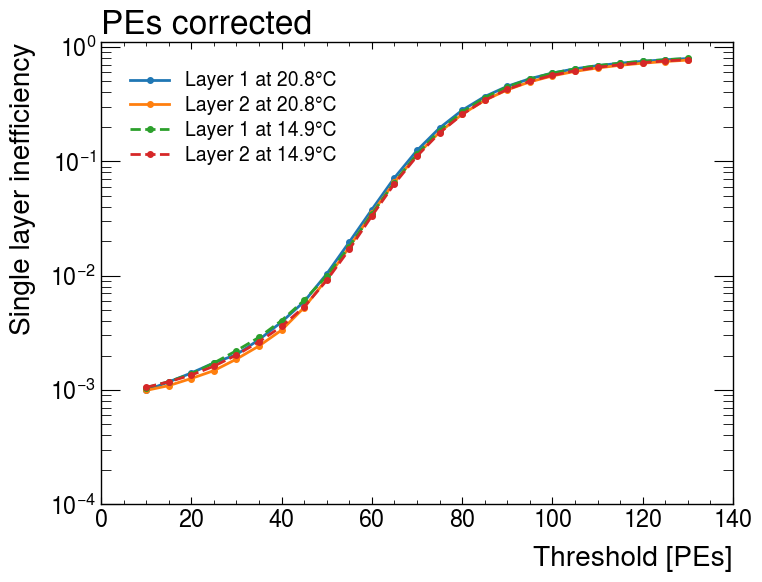

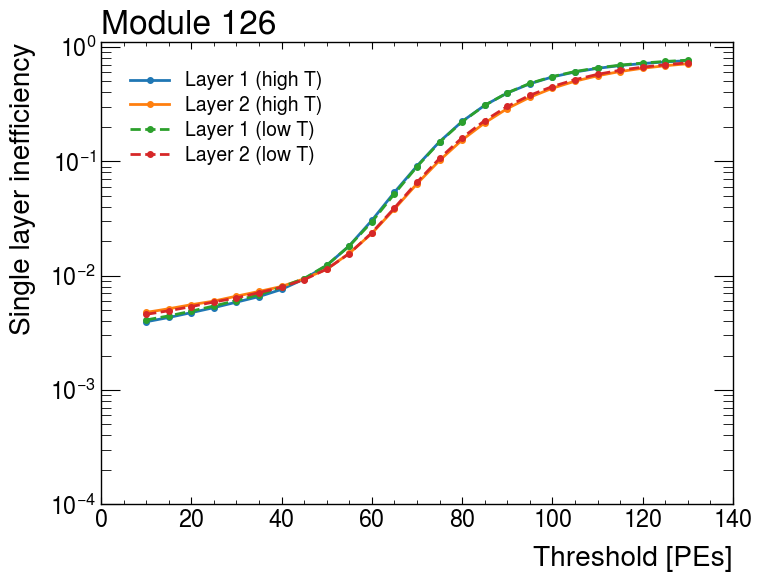

In [6]:
ineff_layer1_127_high = np.zeros_like(thresh)
ineff_layer2_127_high = np.zeros_like(thresh)
ineff_layer1_127_low = np.zeros_like(thresh)
ineff_layer2_127_low = np.zeros_like(thresh)

ineff_layer1_126_high = np.zeros_like(thresh)
ineff_layer2_126_high = np.zeros_like(thresh)
ineff_layer1_126_low = np.zeros_like(thresh)
ineff_layer2_126_low = np.zeros_like(thresh)

for i in range(len(thresh)):
    ineff_1 = 1 - pass_1_127_high[i]/nTrig_module127_high[i]
    ineff_2 = 1 - pass_2_127_high[i]/nTrig_module127_high[i]
    
    ineff_layer1_127_high[i] = ineff_1
    ineff_layer2_127_high[i] = ineff_2
    
    ineff_1 = 1 - pass_1_127_low[i]/nTrig_module127_low[i]
    ineff_2 = 1 - pass_2_127_low[i]/nTrig_module127_low[i]
    
    ineff_layer1_127_low[i] = ineff_1
    ineff_layer2_127_low[i] = ineff_2
    
    ineff_1 = 1 - pass_1_126_high[i]/nTrig_module126_high[i]
    ineff_2 = 1 - pass_2_126_high[i]/nTrig_module126_high[i]
    
    ineff_layer1_126_high[i] = ineff_1
    ineff_layer2_126_high[i] = ineff_2
    
    ineff_1 = 1 - pass_1_126_low[i]/nTrig_module126_low[i]
    ineff_2 = 1 - pass_2_126_low[i]/nTrig_module126_low[i]
    
    ineff_layer1_126_low[i] = ineff_1
    ineff_layer2_126_low[i] = ineff_2
    
fig, ax = plt.subplots()

ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_127_high, '.-', label='Layer 1 at 20.8°C')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_127_high, '.-', label='Layer 2 at 20.8°C')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_127_low, '.--', label='Layer 1 at 14.9°C')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_127_low, '.--', label='Layer 2 at 14.9°C')

plt.legend()
ax.set_ylim(0.0001, 1.1)
ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('Single layer inefficiency')

ax.set_title('PEs corrected',loc='left')

#fig.savefig('efficiency_corrected.png',dpi=2400)

plt.show()

fig, ax = plt.subplots()

ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_126_high, '.-', label='Layer 1 (high T)')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_126_high, '.-', label='Layer 2 (high T)')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_126_low, '.--', label='Layer 1 (low T)')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_126_low, '.--', label='Layer 2 (low T)')

plt.legend()
ax.set_ylim(0.0001, 1.1)
ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('Single layer inefficiency')

ax.set_title('Module 126',loc='left')

plt.show()

In [7]:
# List of variable to import
varlist=['PEs', 'eventNumber']

thresh = np.linspace(10, 130, 25, endpoint=True)
pass_1_126_high = np.zeros_like(thresh)
pass_2_126_high = np.zeros_like(thresh)
pass_1_126_low = np.zeros_like(thresh)
pass_2_126_low = np.zeros_like(thresh)
pass_module126_1of2_high = np.zeros_like(thresh)
pass_module126_1of2_low = np.zeros_like(thresh)
nTrig_module126_high = np.zeros_like(thresh)
nTrig_module126_low = np.zeros_like(thresh)

pass_1_127_high = np.zeros_like(thresh)
pass_2_127_high = np.zeros_like(thresh)
pass_1_127_low = np.zeros_like(thresh)
pass_2_127_low = np.zeros_like(thresh)
pass_module127_1of2_high = np.zeros_like(thresh)
pass_module127_1of2_low = np.zeros_like(thresh)
nTrig_module127_high = np.zeros_like(thresh)
nTrig_module127_low = np.zeros_like(thresh)

highT = False

allevents = 0
highTevents = 0
lowTevents = 0

allfiles = 0
filesloaded = 0

for idx, filename in enumerate(filelist_data):
        with uproot.open(filename) as file:
            for ar in file.iterate(step_size="10MB", 
                                           filter_name=varlist, 
                                           report=False, library='ak'):
                allevents += len(ar["eventNumber"])
                if '1312' in filename:
                    highT = True
                if '1341' in filename:
                    highT = False

                ar["PEs"] = ak.where(ar["PEs"] >= 5, ar["PEs"], 0)

                FEB0_1 = (ak.sum(ar["PEs"][:,0,36:60], axis=-1)>10) #42:64
                FEB1_0 = (ak.sum(ar["PEs"][:,1,4:28], axis=-1)>10) #0:32
                
                FEB4_0 = (ak.sum(ar["PEs"][:,4,4:28], axis=-1)>10) #10:22
                FEB5_1 = (ak.sum(ar["PEs"][:,5,36:60], axis=-1)>10)

                ar_126 = ar[FEB4_0 & FEB5_1]
                ar_127 = ar[FEB1_0 & FEB0_1]

                for j in range(len(thresh)):
                    FEB1_1 = (ak.sum(ar_127["PEs"][:,1,32:64], axis=-1)>thresh[j])
                    FEB0_0 = (ak.sum(ar_127["PEs"][:,0,0:32], axis=-1)>thresh[j])
                    nHits_127 = ak.values_astype(FEB1_1, "int") + ak.values_astype(FEB0_0, "int")
                    
                    FEB4_1 = (ak.sum(ar_126["PEs"][:,4,32:64], axis=-1)>thresh[j])
                    FEB5_0 = (ak.sum(ar_126["PEs"][:,5,0:32], axis=-1)>thresh[j])
                    nHits_126 = ak.values_astype(FEB4_1, "int") + ak.values_astype(FEB5_0, "int")
                    
                    if highT:
                        pass_1_127_high[j] += ak.count(ar_127[FEB1_1]["eventNumber"])
                        pass_2_127_high[j] += ak.count(ar_127[FEB0_0]["eventNumber"])
                        pass_module127_1of2_high[j] += ak.count(ar_127[(nHits_127 >= 1)]["eventNumber"])
                        nTrig_module127_high[j] += ak.count(ar_127["eventNumber"])
                        
                        pass_1_126_high[j] += ak.count(ar_126[FEB4_1]["eventNumber"])
                        pass_2_126_high[j] += ak.count(ar_126[FEB5_0]["eventNumber"])
                        pass_module126_1of2_high[j] += ak.count(ar_126[(nHits_126 >= 1)]["eventNumber"])
                        nTrig_module126_high[j] += ak.count(ar_126["eventNumber"])
                        
                    else:
                        pass_1_127_low[j] += ak.count(ar_127[FEB1_1]["eventNumber"])
                        pass_2_127_low[j] += ak.count(ar_127[FEB0_0]["eventNumber"])
                        pass_module127_1of2_low[j] += ak.count(ar_127[(nHits_127 >= 1)]["eventNumber"])
                        nTrig_module127_low[j] += ak.count(ar_127["eventNumber"])
                        
                        pass_1_126_low[j] += ak.count(ar_126[FEB4_1]["eventNumber"])
                        pass_2_126_low[j] += ak.count(ar_126[FEB5_0]["eventNumber"])
                        pass_module126_1of2_low[j] += ak.count(ar_126[(nHits_126 >= 1)]["eventNumber"])
                        nTrig_module126_low[j] += ak.count(ar_126["eventNumber"])

[0.98145454 1.05387136 1.0885201  1.10057881 1.05331223 1.10008368
 1.19413204 1.35760193 1.5588541  1.78420329 1.93243208 1.92469418
 1.83694791 1.67480421 1.53064141 1.4064855  1.30238544 1.22614237
 1.17116786 1.13029045 1.10061177 1.07913425 1.06299958 1.0517292
 1.04338376]
[0.97626166 0.96854312 0.99328568 0.97124575 1.02846023 1.0706044
 1.14279956 1.32888692 1.57972779 1.75841701 1.8947719  1.84615823
 1.75500412 1.62305015 1.49461488 1.38223671 1.29006139 1.22041695
 1.16679568 1.12659196 1.09587569 1.07535933 1.06069203 1.04957299
 1.04232349]


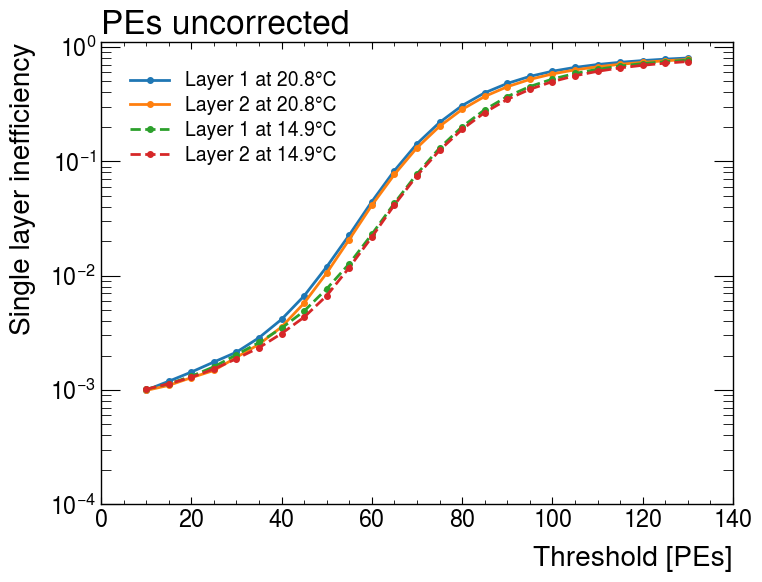

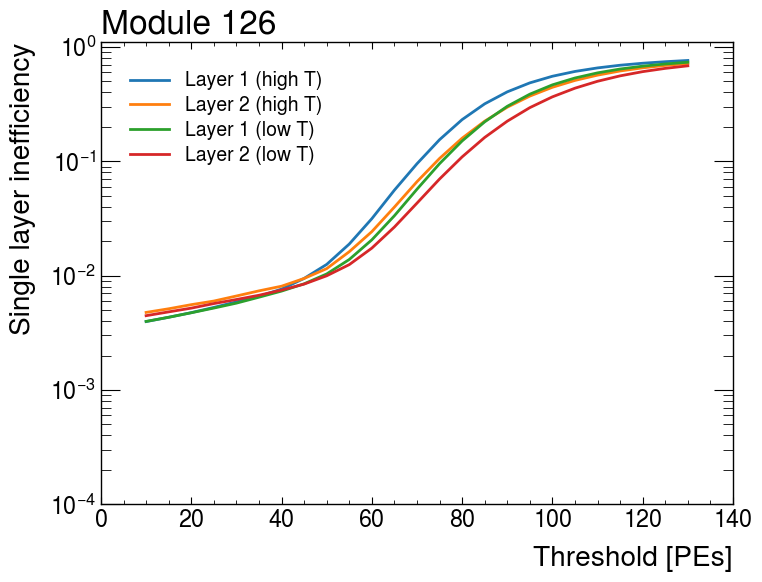

In [8]:
ineff_layer1_127_high = np.zeros_like(thresh)
ineff_layer2_127_high = np.zeros_like(thresh)
ineff_layer1_127_low = np.zeros_like(thresh)
ineff_layer2_127_low = np.zeros_like(thresh)

ineff_layer1_126_high = np.zeros_like(thresh)
ineff_layer2_126_high = np.zeros_like(thresh)
ineff_layer1_126_low = np.zeros_like(thresh)
ineff_layer2_126_low = np.zeros_like(thresh)

for i in range(len(thresh)):
    ineff_1 = 1 - pass_1_127_high[i]/nTrig_module127_high[i]
    ineff_2 = 1 - pass_2_127_high[i]/nTrig_module127_high[i]
    
    ineff_layer1_127_high[i] = ineff_1
    ineff_layer2_127_high[i] = ineff_2
    
    ineff_1 = 1 - pass_1_127_low[i]/nTrig_module127_low[i]
    ineff_2 = 1 - pass_2_127_low[i]/nTrig_module127_low[i]
    
    ineff_layer1_127_low[i] = ineff_1
    ineff_layer2_127_low[i] = ineff_2
    
    ineff_1 = 1 - pass_1_126_high[i]/nTrig_module126_high[i]
    ineff_2 = 1 - pass_2_126_high[i]/nTrig_module126_high[i]
    
    ineff_layer1_126_high[i] = ineff_1
    ineff_layer2_126_high[i] = ineff_2
    
    ineff_1 = 1 - pass_1_126_low[i]/nTrig_module126_low[i]
    ineff_2 = 1 - pass_2_126_low[i]/nTrig_module126_low[i]
    
    ineff_layer1_126_low[i] = ineff_1
    ineff_layer2_126_low[i] = ineff_2
    
ratio1 = np.divide(ineff_layer1_127_high, ineff_layer1_127_low)
ratio2 = np.divide(ineff_layer2_127_high, ineff_layer2_127_low)
print(ratio1)
print(ratio2)
    
fig, ax = plt.subplots()

ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_127_high, '.-', label='Layer 1 at 20.8°C')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_127_high, '.-', label='Layer 2 at 20.8°C')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_127_low, '.--', label='Layer 1 at 14.9°C')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_127_low, '.--', label='Layer 2 at 14.9°C')

plt.legend()
ax.set_ylim(0.0001, 1.1)
ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('Single layer inefficiency')

ax.set_title('PEs uncorrected',loc='left')

plt.show()

fig, ax = plt.subplots()

ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_126_high, '-', label='Layer 1 (high T)')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_126_high, '-', label='Layer 2 (high T)')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_126_low, '-', label='Layer 1 (low T)')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_126_low, '-', label='Layer 2 (low T)')

plt.legend()
ax.set_ylim(0.0001, 1.1)
ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('Single layer inefficiency')

ax.set_title('Module 126',loc='left')

plt.show()